# SimNet Training for Balancing Robot

This notebook trains a SimNet model using both physics simulation data and real-world data.

In [1]:
# Uncomment the following lines to run in Google Colab

# %cd /content
# !git clone https://github.com/EyalPorat/ddpg-balancing-robot.git
# %cd ddpg-balancing-robot
# !git checkout simpler-state
# %cd /content/ddpg-balancing-robot/python/notebooks

# import sys
# sys.path.append('/content/ddpg-balancing-robot/python')  # Add the repo root to Python path

In [2]:
import sys
sys.path.append('..')

import torch
import numpy as np
from pathlib import Path
import json
import yaml
import glob
from matplotlib import pyplot as plt

from src.balancing_robot.models import SimNet
from src.balancing_robot.environment import BalancerEnv
from src.balancing_robot.training import SimNetTrainer
from src.balancing_robot.visualization import plot_predictions_comparison

## Load Configuration

In [3]:
# Load configurations
with open('../configs/simnet_config.yaml', 'r') as f:
    simnet_config = yaml.safe_load(f)

with open('../configs/env_config.yaml', 'r') as f:
    env_config = yaml.safe_load(f)

# Create directories
log_dir = Path('logs/simnet_training')
log_dir.mkdir(parents=True, exist_ok=True)

## Initialize Models and Environment

In [4]:
# Set random seeds
torch.manual_seed(simnet_config['data_collection']['random_seed'])
np.random.seed(simnet_config['data_collection']['random_seed'])

# Create environment for physics data
env = BalancerEnv(config_path='../configs/env_config.yaml')

# Initialize trainer with config
trainer = SimNetTrainer(
    env=env,
    config_path='../configs/simnet_config.yaml'
)

c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## Collect and Process Physics Data

In [5]:
# Collect physics simulation data
train_data, val_data = trainer.collect_physics_data()

print(f"Collected {len(train_data['states'])} training samples")
print(f"Collected {len(val_data['states'])} validation samples")

Collected 1644116 training samples
Collected 411028 validation samples


## Train on Physics Data

In [6]:
# Train on physics data
physics_history = trainer.train(
    train_data=train_data,
    val_data=val_data,
    is_finetuning=False,
    log_dir=log_dir / 'physics'
)

Epoch 1/30 - Train Loss: 4.442409 - Val Loss: 2.025901
Epoch 2/30 - Train Loss: 1.171655 - Val Loss: 0.589017
Epoch 3/30 - Train Loss: 0.322814 - Val Loss: 0.152720
Epoch 4/30 - Train Loss: 0.085247 - Val Loss: 0.044978
Epoch 5/30 - Train Loss: 0.028312 - Val Loss: 0.018178
Epoch 6/30 - Train Loss: 0.013209 - Val Loss: 0.010270
Epoch 7/30 - Train Loss: 0.008455 - Val Loss: 0.007401
Epoch 8/30 - Train Loss: 0.006576 - Val Loss: 0.006122
Epoch 9/30 - Train Loss: 0.005650 - Val Loss: 0.005411
Epoch 10/30 - Train Loss: 0.005129 - Val Loss: 0.004988
Epoch 11/30 - Train Loss: 0.004787 - Val Loss: 0.004693
Epoch 12/30 - Train Loss: 0.004544 - Val Loss: 0.004472
Epoch 13/30 - Train Loss: 0.004364 - Val Loss: 0.004308
Epoch 14/30 - Train Loss: 0.004222 - Val Loss: 0.004175
Epoch 15/30 - Train Loss: 0.004103 - Val Loss: 0.004042
Epoch 16/30 - Train Loss: 0.003964 - Val Loss: 0.003913
Epoch 17/30 - Train Loss: 0.003847 - Val Loss: 0.003805
Epoch 18/30 - Train Loss: 0.003762 - Val Loss: 0.003730
E

In [7]:
# Save physics trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_physics_final.pt')

simnet_physics = SimNet(
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.shape[0],
    hidden_dims=simnet_config['model']['hidden_dims']
)
simnet_physics.load_state_dict(torch.load(log_dir / 'simnet_physics_final.pt')['state_dict'])

<All keys matched successfully>

## Load and Process Real-World Data

In [8]:
# Find all files that start with robot_logs and end with .json
log_files = glob.glob('../data/robot_logs*.json')
print(f"Found {len(log_files)} log files: {log_files}")

# Initialize empty list to store all episodes
all_episodes = []

# Load and append data from each file
for log_file in log_files:
    with open(log_file, 'r') as f:
        log_data = json.load(f)
        # Append episodes from this file
        all_episodes.extend(log_data['episodes'])
        print(f"Loaded {len(log_data['episodes'])} episodes from {log_file}")

# Process combined data
real_train_data, real_val_data = trainer.process_real_data(all_episodes)
print(f"Processed {len(real_train_data['states'])} real training samples")
print(f"Processed {len(real_val_data['states'])} real validation samples")

Found 5 log files: ['../data\\robot_logs_20250308_205032_no_motor.json', '../data\\robot_logs_20250308_205436_with_motor.json', '../data\\robot_logs_20250309_132939_with_motor.json', '../data\\robot_logs_20250310_001210_with_motor.json', '../data\\robot_logs_20250310_001522_no_motor.json']
Loaded 40 episodes from ../data\robot_logs_20250308_205032_no_motor.json
Loaded 14 episodes from ../data\robot_logs_20250308_205436_with_motor.json
Loaded 22 episodes from ../data\robot_logs_20250309_132939_with_motor.json
Loaded 9 episodes from ../data\robot_logs_20250310_001210_with_motor.json
Loaded 27 episodes from ../data\robot_logs_20250310_001522_no_motor.json
Processed 8129 real training samples
Processed 2032 real validation samples


## Fine-tune on Real Data

In [9]:
# Fine-tune on real data
real_history = trainer.train(
    train_data=real_train_data,
    val_data=real_val_data,
    is_finetuning=True,
    log_dir=log_dir / 'real'
)

Epoch 1/30 - Train Loss: 1.704956 - Val Loss: 1.484271
Epoch 2/30 - Train Loss: 1.596498 - Val Loss: 1.422755
Epoch 3/30 - Train Loss: 1.532702 - Val Loss: 1.380907
Epoch 4/30 - Train Loss: 1.485956 - Val Loss: 1.348745
Epoch 00035: reducing learning rate of group 0 to 2.5000e-06.
Epoch 5/30 - Train Loss: 1.448705 - Val Loss: 1.322535
Epoch 6/30 - Train Loss: 1.424796 - Val Loss: 1.311233
Epoch 7/30 - Train Loss: 1.410844 - Val Loss: 1.300998
Epoch 8/30 - Train Loss: 1.398084 - Val Loss: 1.291646
Epoch 9/30 - Train Loss: 1.386311 - Val Loss: 1.282994
Epoch 00040: reducing learning rate of group 0 to 1.2500e-06.
Epoch 10/30 - Train Loss: 1.375348 - Val Loss: 1.274924
Epoch 11/30 - Train Loss: 1.367553 - Val Loss: 1.271106
Epoch 12/30 - Train Loss: 1.362620 - Val Loss: 1.267438
Epoch 13/30 - Train Loss: 1.357858 - Val Loss: 1.263894
Epoch 14/30 - Train Loss: 1.353245 - Val Loss: 1.260465
Epoch 00045: reducing learning rate of group 0 to 6.2500e-07.
Epoch 15/30 - Train Loss: 1.348773 - Va

## Analyze Data Distribution

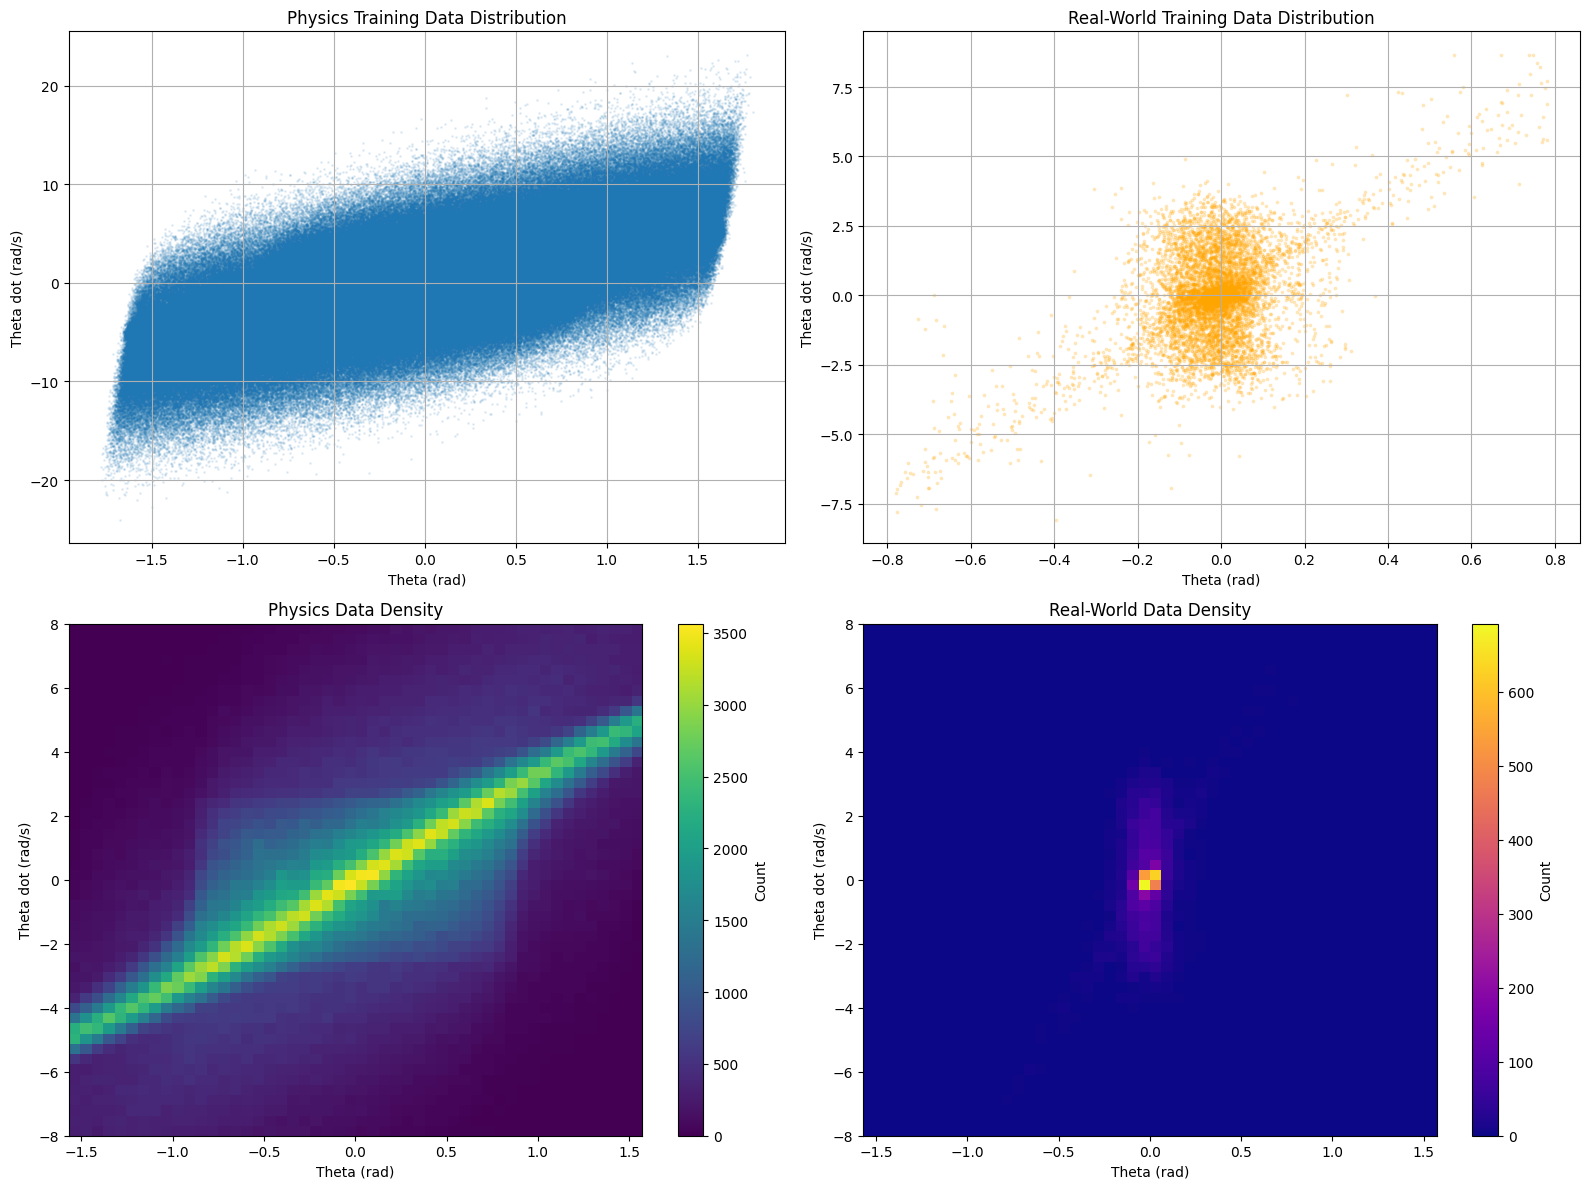

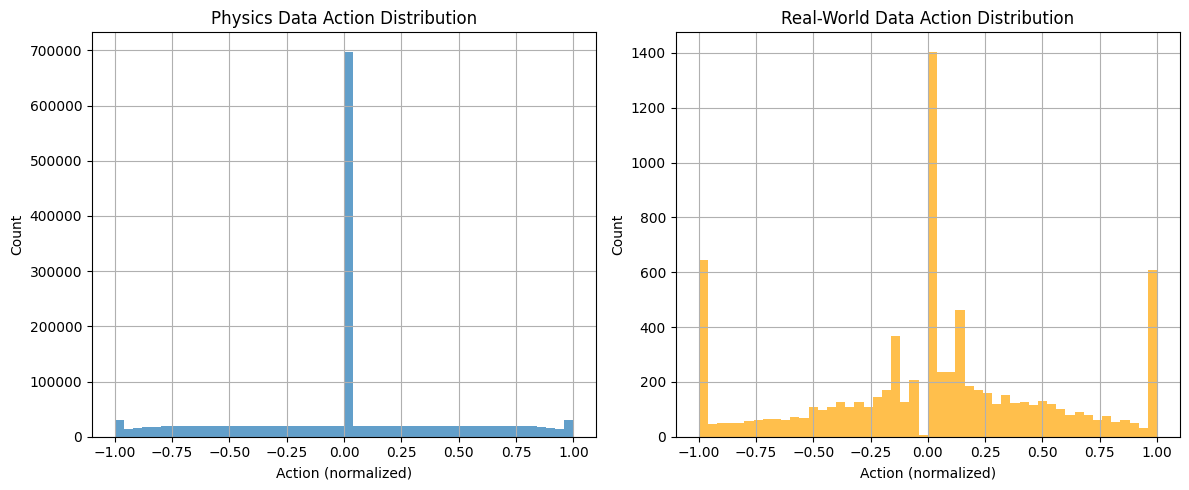

In [ ]:
# Create scatter plots and heatmaps to visualize the distribution of data
plt.figure(figsize=(16, 12))

# Physics data distribution
plt.subplot(2, 2, 1)
plt.scatter(train_data['states'][:, 0], train_data['states'][:, 1], alpha=0.1, s=1)
plt.title('Physics Training Data Distribution')
plt.xlabel('Theta (rad)')
plt.ylabel('Theta dot (rad/s)')
plt.grid(True)

# Real data distribution
plt.subplot(2, 2, 2)
plt.scatter(real_train_data['states'][:, 0], real_train_data['states'][:, 1], alpha=0.2, s=3, c='orange')
plt.title('Real-World Training Data Distribution')
plt.xlabel('Theta (rad)')
plt.ylabel('Theta dot (rad/s)')
plt.grid(True)

# Physics data heatmap
plt.subplot(2, 2, 3)
h_physics, xedges, yedges = np.histogram2d(
    train_data['states'][:, 0], 
    train_data['states'][:, 1], 
    bins=[50, 50], 
    range=[[-np.pi/2, np.pi/2], [-8, 8]]
)
plt.imshow(h_physics.T, origin='lower', aspect='auto', 
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
          cmap='viridis')
plt.colorbar(label='Count')
plt.title('Physics Data Density')
plt.xlabel('Theta (rad)')
plt.ylabel('Theta dot (rad/s)')

# Real data heatmap
plt.subplot(2, 2, 4)
h_real, xedges, yedges = np.histogram2d(
    real_train_data['states'][:, 0], 
    real_train_data['states'][:, 1], 
    bins=[50, 50], 
    range=[[-np.pi/2, np.pi/2], [-8, 8]]
)
plt.imshow(h_real.T, origin='lower', aspect='auto', 
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
          cmap='plasma')
plt.colorbar(label='Count')
plt.title('Real-World Data Density')
plt.xlabel('Theta (rad)')
plt.ylabel('Theta dot (rad/s)')

plt.tight_layout()
plt.savefig(log_dir / "data_distribution.png")
plt.show()

# Compare the action distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_data['actions'], bins=50, alpha=0.7)
plt.title('Physics Data Action Distribution')
plt.xlabel('Action (normalized)')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(real_train_data['actions'], bins=50, alpha=0.7, color='orange')
plt.title('Real-World Data Action Distribution')
plt.xlabel('Action (normalized)')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()
plt.savefig(log_dir / "action_distribution.png")
plt.show()

## Analyze Predictions

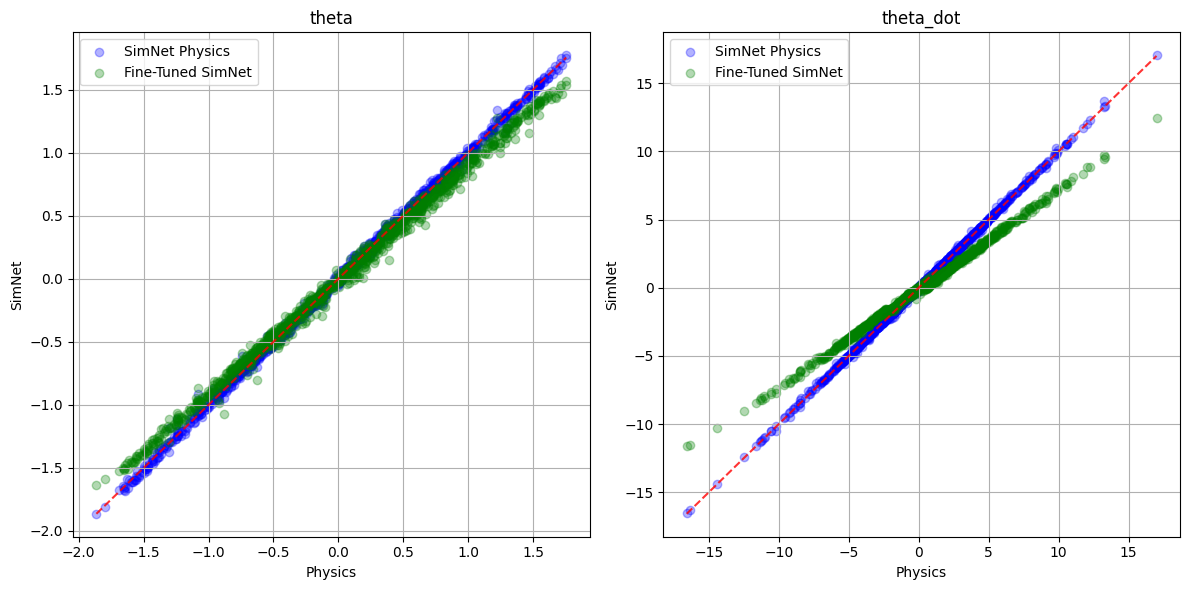

In [13]:

test_states = val_data["states"][:1000]
test_actions = val_data["actions"][:1000]
physics_preds = val_data["next_states"][:1000]  # The actual next states from the physics data

# Get SimNet predictions
simnet_preds = []
simnet_physics_preds = []
for s, a in zip(test_states, test_actions):
    s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    a_tensor = torch.tensor(a, dtype=torch.float32).unsqueeze(0)
    pred_next = trainer.simnet(s_tensor, a_tensor).detach().numpy()[0]
    simnet_preds.append(pred_next)
    pred_next_physics = simnet_physics(s_tensor, a_tensor).detach().numpy()[0]
    simnet_physics_preds.append(pred_next_physics)
simnet_preds = np.array(simnet_preds)
simnet_physics_preds = np.array(simnet_physics_preds)

# Plot comparison (assuming your plot function looks something like this)
fig = plot_predictions_comparison(
    physics_preds=physics_preds,   # ground-truth next states
    simnet_preds=simnet_preds,     # network-predicted next states
    simnet_physics_preds=simnet_physics_preds,  # network-predicted next states using simnet physics model
    save_path=log_dir / "prediction_comparison.png"
)
plt.show()


## Evaluate Learning Curves

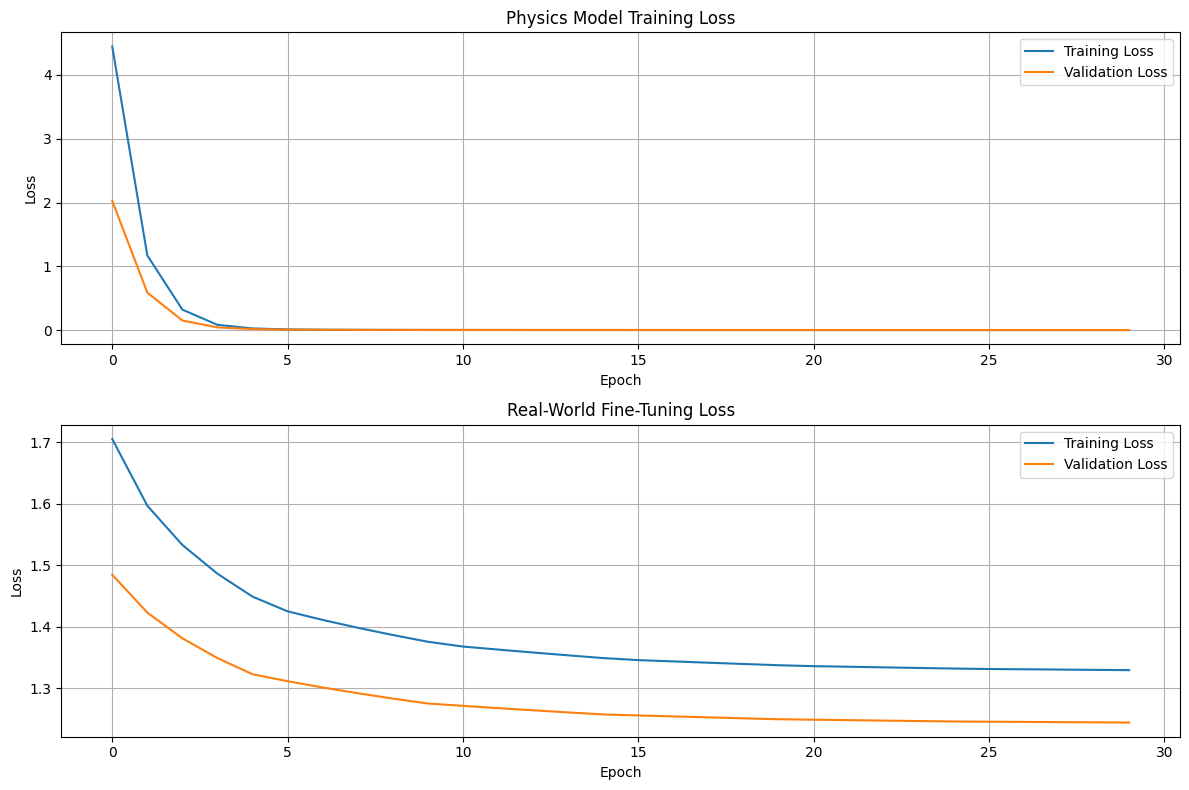

In [ ]:
# Extract training losses from history data
physics_train_losses = [epoch['train_loss'] for epoch in physics_history]
physics_val_losses = [epoch['val_loss'] for epoch in physics_history]
real_train_losses = [epoch['train_loss'] for epoch in real_history]
real_val_losses = [epoch['val_loss'] for epoch in real_history]

# Create figure for loss plots
plt.figure(figsize=(12, 8))

# Plot physics training loss
plt.subplot(2, 1, 1)
plt.plot(physics_train_losses, label='Training Loss')
plt.plot(physics_val_losses, label='Validation Loss')
plt.title('Physics Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot real-world fine-tuning loss
plt.subplot(2, 1, 2)
plt.plot(real_train_losses, label='Training Loss')
plt.plot(real_val_losses, label='Validation Loss')
plt.title('Real-World Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(log_dir / "loss_curves.png")
plt.show()

## Save Final Model

In [14]:
# Save trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'real_history': real_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_final.pt')
